<a href="https://colab.research.google.com/github/codedmachine111/musify-deep-learning-model/blob/important-labels-model/musify_emotion_detection_important_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets -q

In [4]:
import opendatasets as od
data_url="https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer"
od.download(data_url)

100%|██████████| 65.2M/65.2M [00:04<00:00, 17.1MB/s]


In [5]:
root_dir = "/content/emotion-detection-fer/"
train_dir = "/content/emotion-detection-fer/train/"
test_dir = "/content/emotion-detection-fer/test/"

In [6]:
!rm -rf /content/emotion-detection-fer/test/fearful
!rm -rf /content/emotion-detection-fer/test/surprised
!rm -rf /content/emotion-detection-fer/test/angry
!rm -rf /content/emotion-detection-fer/test/disgusted
!rm -rf /content/emotion-detection-fer/train/fearful
!rm -rf /content/emotion-detection-fer/train/surprised
!rm -rf /content/emotion-detection-fer/train/angry
!rm -rf /content/emotion-detection-fer/train/disgusted


In [7]:
import os
target_var = os.listdir(train_dir)
target_var

['happy', 'sad', 'neutral']

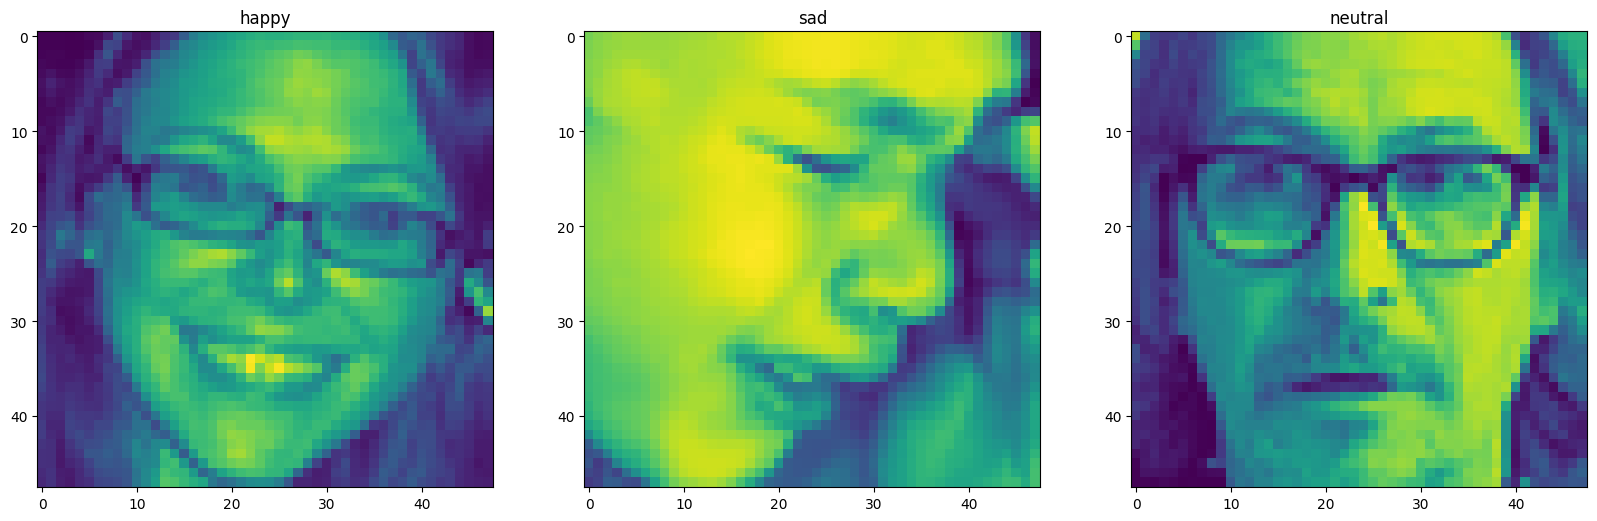

In [8]:
# Sample images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20,8))
for i in range(len(target_var)):
    d = train_dir+target_var[i]+'/'+os.listdir(train_dir+target_var[i]+'/')[0]
    axes[i].imshow( plt.imread(d) )
    axes[i].set_title(target_var[i])
plt.show()

Emotion :happy
Train :7215
Test :1774


Emotion :sad
Train :4830
Test :1247


Emotion :neutral
Train :4965
Test :1233




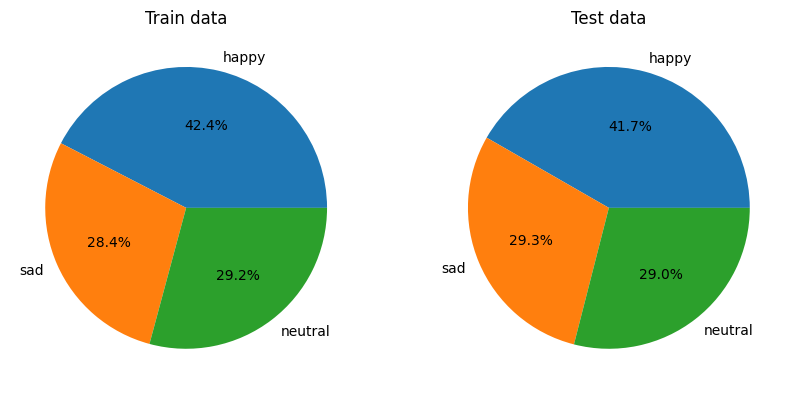

In [9]:
# Exploring the distribution of data
import numpy as np

x_train = np.array([ len(os.listdir(train_dir+i+'/')) for i in os.listdir(train_dir)])
x_test = np.array([ len(os.listdir(test_dir+i+'/')) for  i in os.listdir(test_dir)])
label = target_var

fig, axes = plt.subplots(1, 2, figsize=(10,8))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%')
axes[0].set_title("Train data")
axes[1].pie(x_test, labels=label, autopct='%1.1f%%')
axes[1].set_title("Test data");

for i in target_var:
  print(f"Emotion :" + i)
  print(f"Train :"+ str(len(os.listdir(train_dir+i+'/'))))
  print(f"Test :"+ str(len(os.listdir(test_dir+i+'/'))))
  print("\n")

In [10]:
# Data Augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_idg = ImageDataGenerator(rescale=1./255 , validation_split=0.3, rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    )

test_idg = ImageDataGenerator(rescale=1./255, rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,)

img_size = (48,48)
batch_size = 32

train_args = {
    'target_size': img_size,
    'batch_size': batch_size,
    'color_mode': 'grayscale',
    'class_mode': 'categorical',
    'shuffle':True
}

test_args = {
    'target_size': img_size,
    'batch_size': batch_size,
    'color_mode': 'grayscale',
    'class_mode': 'categorical',
    'shuffle': False,
}

train = train_idg.flow_from_directory(directory=train_dir, subset='training', **train_args)
valid = train_idg.flow_from_directory(directory=train_dir, subset='validation', **train_args)
test = test_idg.flow_from_directory(directory=test_dir, **test_args)

Found 11908 images belonging to 3 classes.
Found 5102 images belonging to 3 classes.
Found 4254 images belonging to 3 classes.


In [11]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Dropout, MaxPooling2D, Activation

model = tf.keras.Sequential()

# A single input layer consisting of two consecutive 2D convolutional layers, 
# each with 32 filters of size 3x3 and using a rectified linear unit (ReLU) activation function. 
# Batch normalization is applied after each convolutional layer to normalize the input to the next layer. 
# A max pooling layer with a pool size of 2x2 is used to reduce the spatial dimensions of the output,
# and a dropout layer with a rate of 0.2 is applied to randomly drop 20% of the neurons in the layer during training.

model.add(Conv2D(64,(5,5), padding='same', kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(5,5),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# This is a hidden layer. It consists of two Conv2D layers, each with 64 filters, 
# followed by ReLU activation function, BatchNormalization, MaxPooling2D layer 
# with a pool size of (2,2), and Dropout regularization with a rate of 0.2.

model.add(Conv2D(128,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# This is a hidden layer. It consists of two Conv2D layers, each with 256 filters, 
# followed by ReLU activation function, BatchNormalization, MaxPooling2D layer 
# with a pool size of (2,2), and Dropout regularization with a rate of 0.2.

model.add(Conv2D(256,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# This is the output layer with 2 Dense layers of 64 units and a final Dense layer with 7 outputs
model.add(Flatten())
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Dense(3, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'], 
              optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
              )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                        

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

In [ ]:
%time
model.fit(train, 
          validation_data=valid,
          epochs=100, 
          callbacks=[early_stopping, lr_scheduler], 
          use_multiprocessing=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
Epoch 1/100
373/373 [==============================] - 48s 60ms/step - loss: 1.5193 - accuracy: 0.3538 - val_loss: 1.0913 - val_accuracy: 0.4075 - lr: 0.0010
Epoch 2/100
373/373 [==============================] - 28s 75ms/step - loss: 1.1438 - accuracy: 0.3952 - val_loss: 1.0755 - val_accuracy: 0.4218 - lr: 0.0010
Epoch 3/100
373/373 [==============================] - 29s 76ms/step - loss: 1.0812 - accuracy: 0.4239 - val_loss: 1.0580 - val_accuracy: 0.4479 - lr: 0.0010
Epoch 4/100
373/373 [==============================] - 28s 76ms/step - loss: 1.0644 - accuracy: 0.4370 - val_loss: 1.0475 - val_accuracy: 0.4673 - lr: 0.0010
Epoch 5/100
373/373 [==============================] - 28s 76ms/step - loss: 1.0465 - accuracy: 0.4608 - val_loss: 1.0235 - val_accuracy: 0.4898 - lr: 0.0010
Epoch 6/100
373/373 [==============================] - 28s 75ms/step - loss: 1.0168 - accuracy: 0.4890 - val_loss: 0.9569 - val_accuracy: 0.5300 -

In [13]:
!cp -r /content/drive/MyDrive/model-min-label.h5 /content


In [14]:
import tensorflow_hub as hub
model = tf.keras.models.load_model('/content/model-min-label.h5', custom_objects={"KerasLayer":hub.KerasLayer})

In [ ]:
model.save("model-min-label.h5")

In [15]:
# Make predictions
y_pred = model.predict(test)
y_pred

133/133 [==============================] - 12s 31ms/step


array([[9.9770135e-01, 9.7759848e-04, 1.3210519e-03],
       [8.3799899e-01, 1.5223081e-01, 9.7701987e-03],
       [9.1255260e-01, 4.0727737e-03, 8.3374612e-02],
       ...,
       [7.0180772e-03, 4.3595415e-02, 9.4938648e-01],
       [2.3170177e-02, 7.9980844e-01, 1.7702140e-01],
       [3.8798148e-04, 4.2817578e-02, 9.5679444e-01]], dtype=float32)

In [16]:
pred_labels = []
for i in y_pred:
  pred_labels.append((np.argmax(i)))

len(pred_labels)

4254

In [17]:
y_actual = test.classes[test.index_array]
len(y_actual)

4254

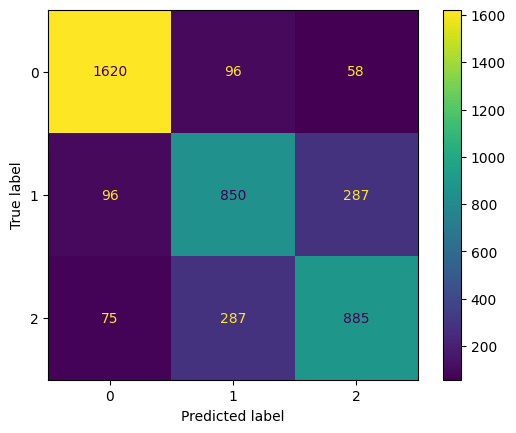

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_actual, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [19]:
acc = np.sum(np.diag(cm)) / np.sum(cm)
print("Test accuracy : ", acc)

Test accuracy :  0.7886694875411377


In [21]:
!cp -r /content/drive/MyDrive/haarcascade_frontalface_default.xml /content

In [22]:
import cv2

# Load the Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Define a function to preprocess the input image
def preprocess_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Detect faces in the image using the Haar Cascade Classifier
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    # If no faces are detected, return None
    if len(faces) == 0:
        return None
    # Extract the first face detected (assuming only one face in the image)
    x, y, w, h = faces[0]
    # Crop the image to the face region
    face_roi = gray[y:y+h, x:x+w]
    # Resize the image to the expected input size of the emotion recognition model
    resized = cv2.resize(face_roi, (48, 48), interpolation=cv2.INTER_AREA)
    # Reshape the image to the expected input shape of the emotion recognition model
    reshaped = np.reshape(resized, (1, 48, 48, 1))
    # Normalize the pixel values to the range [0, 1]
    normalized = reshaped / 255.0
    # Return the preprocessed image
    return normalized

1/1 [==============================] - 0s 20ms/step


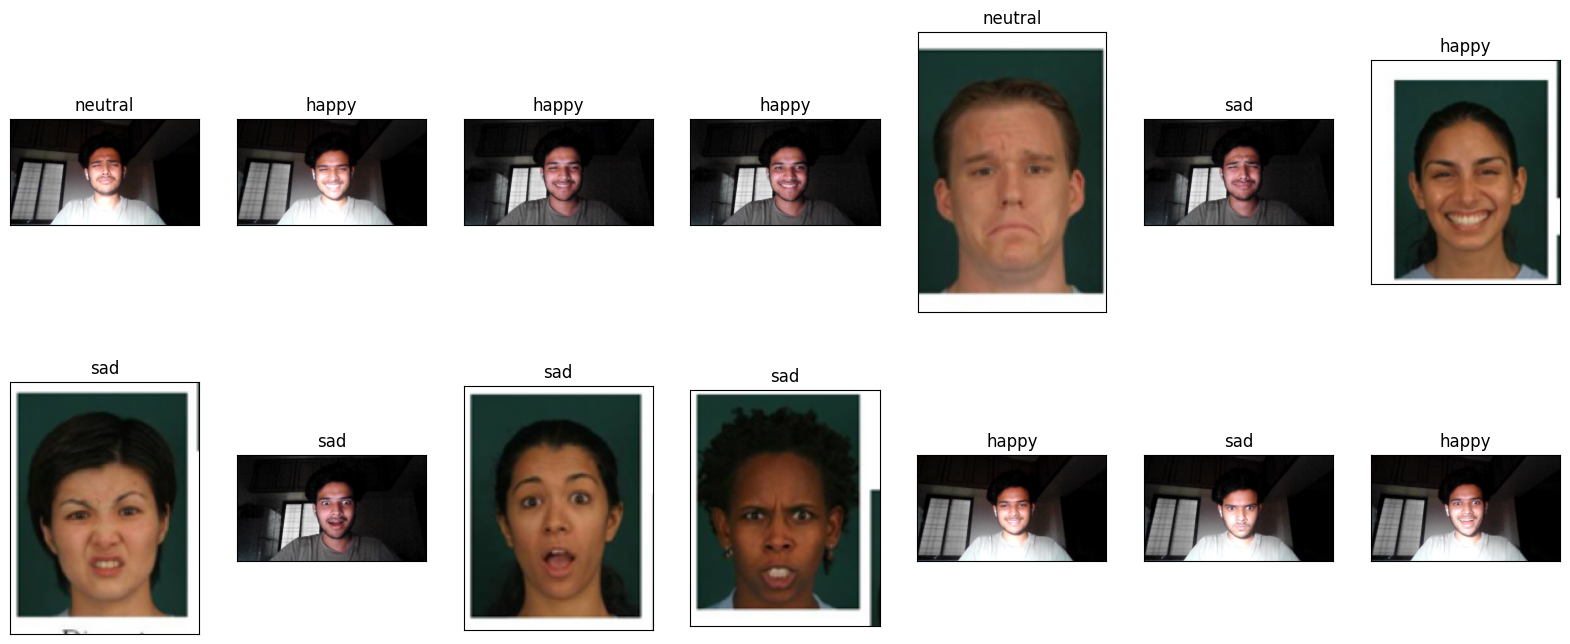

In [32]:
custom_dir = "/content/emotion-custom-images/"
predictions=[]

for img in os.listdir(custom_dir):
  image = cv2.imread(os.path.join(custom_dir, img))
  preprocessed_image = preprocess_image(image)

  # if preprocessed_image is None:
  #   print('No faces detected!')
  #   exit()
  
  predictions.append(model.predict(preprocessed_image))


fig, axes = plt.subplots(2,7, figsize=(20,8))
for i, img in enumerate(os.listdir(custom_dir)):
    d = os.path.join(custom_dir,img)
    axes[i//7, i%7].imshow(plt.imread(d))
    axes[i//7, i%7].set_title(target_var[np.argmax(predictions[i])])
    axes[i//7, i%7].set_xticks([])
    axes[i//7, i%7].set_yticks([])

plt.show()

In [33]:
!pip install tensorflowjs -q
!tensorflowjs_converter --input_format keras /content/model-min-label.h5 /content/final-min-label-model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 114.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav